<a href="https://colab.research.google.com/github/saritmaitra/ATM-cash-withdrawal-forecast/blob/master/ATM_cash_withdrawal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')
import math
from scipy import stats
from google.colab import files
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from sklearn import metrics
from time import time
from sklearn.model_selection import cross_val_score
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from sklearn.linear_model import LinearRegression

# ATM Cash demand forecast

In [1]:
from google.colab import files
uploaded = files.upload()

Saving atm_data.csv to atm_data.csv


In [2]:
# Import data 
df = pd.read_csv("atm_data.csv")
df

<IPython.core.display.Javascript object>

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600,897100
1,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600,826000
2,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600,754400
3,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600,834200
4,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600,575300
...,...,...,...,...,...,...,...,...,...,...,...
2239,11565,Mount Road ATM,MONDAY,NH,W,HWW,5,9,2017,276058,447400
2240,11570,Mount Road ATM,TUESDAY,NH,W,WWW,6,9,2017,276058,153800
2241,11575,Mount Road ATM,WEDNESDAY,NH,W,WWW,6,9,2017,276058,167100
2242,11580,Mount Road ATM,THURSDAY,NH,W,WWH,6,9,2017,276058,317400


In [3]:
data = df.set_index('trans_year').tail()
data.tail()

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,prevweek_mean,total_amount_withdrawn
trans_year,,,,,,,,,,
2017,11565,Mount Road ATM,MONDAY,NH,W,HWW,5,9,276058,447400
2017,11570,Mount Road ATM,TUESDAY,NH,W,WWW,6,9,276058,153800
2017,11575,Mount Road ATM,WEDNESDAY,NH,W,WWW,6,9,276058,167100
2017,11580,Mount Road ATM,THURSDAY,NH,W,WWH,6,9,276058,317400
2017,11585,Mount Road ATM,FRIDAY,H,H,WHH,6,9,276058,305100


In [5]:
df[['trans_month', 'trans_year', 'total_amount_withdrawn']][2017:]

,trans_month,trans_year,total_amount_withdrawn
2017,1,2017,114900
2018,2,2017,99600
2019,2,2017,648800
2020,2,2017,410500
2021,2,2017,380700
...,...,...,...
2239,9,2017,447400
2240,9,2017,153800
2241,9,2017,167100
2242,9,2017,317400


In [6]:
df['total_amount_withdrawn'] [2011:]

2011    347900
2012    111000
2013    245300
2014    355400
2015    338300
         ...  
2239    447400
2240    153800
2241    167100
2242    317400
2243    305100
Name: total_amount_withdrawn, Length: 233, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

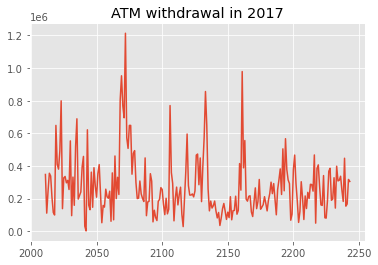

In [8]:
plt.style.use('ggplot')
plt.plot(df['total_amount_withdrawn'] [2011:])
plt.title('ATM withdrawal in 2017')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              2244 non-null   int64 
 1   atm_name                2244 non-null   object
 2   weekday                 2244 non-null   object
 3   festival_religion       2244 non-null   object
 4   working_day             2244 non-null   object
 5   holiday_sequence        2244 non-null   object
 6   trans_date_set          2244 non-null   int64 
 7   trans_month             2244 non-null   int64 
 8   trans_year              2244 non-null   int64 
 9   prevweek_mean           2244 non-null   int64 
 10  total_amount_withdrawn  2244 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 193.0+ KB


### Target analysis
Target distribution is skewed and can be seen in the plots below - this is generally not a good thing. So we will need to adjust it so its normally distributed. This can be achieved with a log transform or something more powerful like box cox. On the diagram below, the left pane shows the original (skewed) data. The right pane show the transformed data.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

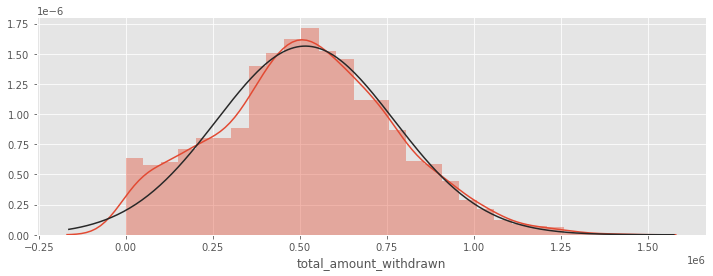

In [10]:
from scipy import stats
fig, ax = plt.subplots(1)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df['total_amount_withdrawn'],fit=stats.norm)
plt.show()

In [11]:
# Copy the original data
features = df.copy()

# Select the numeric columns
numeric_subset = df[['trans_date_set','trans_month','trans_year','prevweek_mean', 'total_amount_withdrawn']]

# Select the categorical columns
# dropped atm_name
categorical_subset = df[['weekday','festival_religion', 'working_day',	'holiday_sequence']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
features.tail()

,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,weekday_FRIDAY,weekday_MONDAY,weekday_SATURDAY,weekday_SUNDAY,weekday_THURSDAY,weekday_TUESDAY,weekday_WEDNESDAY,festival_religion_C,festival_religion_H,festival_religion_M,festival_religion_N,festival_religion_NH,working_day_H,working_day_W,holiday_sequence_HHH,holiday_sequence_HHW,holiday_sequence_HWH,holiday_sequence_HWW,holiday_sequence_WHH,holiday_sequence_WHW,holiday_sequence_WWH,holiday_sequence_WWW
2239,5,9,2017,276058,447400,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
2240,6,9,2017,276058,153800,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2241,6,9,2017,276058,167100,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2242,6,9,2017,276058,317400,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2243,6,9,2017,276058,305100,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   trans_date_set          2244 non-null   int64
 1   trans_month             2244 non-null   int64
 2   trans_year              2244 non-null   int64
 3   prevweek_mean           2244 non-null   int64
 4   total_amount_withdrawn  2244 non-null   int64
 5   weekday_FRIDAY          2244 non-null   uint8
 6   weekday_MONDAY          2244 non-null   uint8
 7   weekday_SATURDAY        2244 non-null   uint8
 8   weekday_SUNDAY          2244 non-null   uint8
 9   weekday_THURSDAY        2244 non-null   uint8
 10  weekday_TUESDAY         2244 non-null   uint8
 11  weekday_WEDNESDAY       2244 non-null   uint8
 12  festival_religion_C     2244 non-null   uint8
 13  festival_religion_H     2244 non-null   uint8
 14  festival_religion_M     2244 non-null   uint8
 15  festival_religion_N  

In [14]:
X = features.copy().drop(columns = ['total_amount_withdrawn', 'trans_date_set', 'trans_month', 
                                    'trans_year', 'working_day_H', 'working_day_W'])
y = features['total_amount_withdrawn'].copy()

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of Xtrain and Xtest: ', len(Xtrain), len(Xtest))
print('length of ytrain and ytest: ', len(ytrain), len(ytest))

<IPython.core.display.Javascript object>

length of Xtrain and Xtest:  1795 449
length of ytrain and ytest:  1795 449


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

## Linear Regression

In [24]:
linear = LinearRegression()
linear.fit(Xtrain, ytrain)

Xtest_scaled = scaler.transform(Xtest)
# make predictions
lin_pred = linear.predict(Xtest)

In [25]:
linpred = pd.DataFrame(lin_pred[-10:])
linpred.rename(columns = {0: 'lin_predicted'}, inplace=True)
linpred = linpred.round(decimals=0)

d = pd.DataFrame(df['total_amount_withdrawn']).tail(10)
d.reset_index(inplace=True)

linok = pd.concat([linpred['lin_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
linok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,lin_predicted,total_amount_withdrawn
0,508440.0,308400
1,488103.0,312600
2,461633.0,337100
3,572903.0,251100
4,374079.0,182700
5,530596.0,447400
6,506257.0,153800
7,518418.0,167100
8,524031.0,317400
9,209299.0,305100


In [26]:
mean_lin_test = ytest.mean()
mean_lin_pred = lin_pred.mean()
print(mean_lin_test, mean_lin_pred)

accuracy = (mean_lin_pred / mean_lin_test)*100
print('accuracy:', round(accuracy,2))


246600.89086859688 480655.8517569127
accuracy: 194.91


## XGBoost

In [29]:
xgb = XGBRegressor(objective = 'reg:squarederror')
xgb.fit(Xtrain, ytrain)
# make predictions
xgb_pred = xgb.predict(Xtest)

In [30]:
xgbpred = pd.DataFrame(xgb_pred[-10:])
xgbpred.rename(columns = {0: 'xgb_predicted'}, inplace=True)
xgbpred = xgbpred.round(decimals=0)

xgbok = pd.concat([xgbpred['xgb_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
xgbok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,xgb_predicted,total_amount_withdrawn
0,199303.0,308400
1,217732.0,312600
2,233046.0,337100
3,208737.0,251100
4,277141.0,182700
5,263519.0,447400
6,271802.0,153800
7,253372.0,167100
8,271802.0,317400
9,148593.0,305100


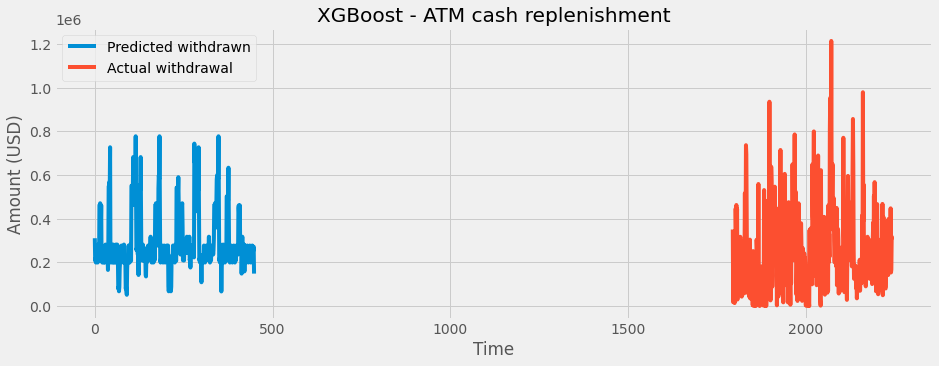

In [31]:
plt.figure(figsize = (14,5))
plt.plot(xgb_pred, label = 'Predicted withdrawn')
plt.plot(ytest, label = 'Actual withdrawal')
plt.title ('XGBoost - ATM cash replenishment')
plt.xlabel('Time')
plt.ylabel('Amount (USD)')
plt.legend()
plt.show()

In [32]:
mean_xgb_test = ytest.mean()
mean_xgb_pred = xgb_pred.mean()
print(mean_xgb_test, mean_xgb_pred)

accuracy = (mean_xgb_pred / mean_xgb_test)*100
print('accuracy:', round(accuracy,2))


246600.89086859688 288215.62
accuracy: 116.88


In [33]:
pip install shap

     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394125 sha256=77bfe5cc0fcccf2750c81ffcab9deb99410bb236e02587cd87753e08043de95e
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


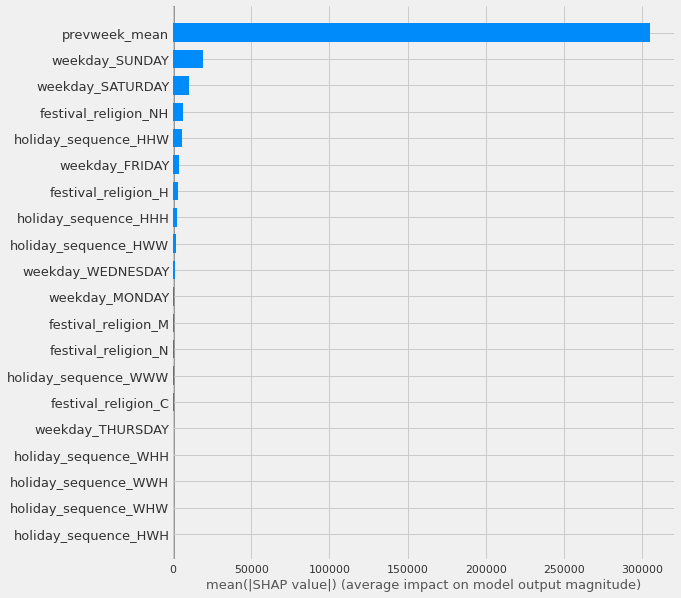

In [35]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="bar")

In [36]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
# j will be the record we explain
j = 1

explainerXGB = shap.TreeExplainer(xgb)
shap_values_XGB_test = explainerXGB.shap_values(Xtest)
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], Xtest.iloc[[j]])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [38]:
# visualize the training set predictions
# load JS visualization code to notebook
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values, Xtest)

## Artifical neural network

In [ ]:
Data = features.values # converting numpy array
tr_data = math.ceil(len(Data)*0.8)
te_data = len(features) - tr_data # remaining is test data
print(tr_data, te_data)

# split the actual dataframe in train/test set
train, test = features.iloc[0:tr_data], features.iloc[tr_data : len(features)]
print(train.shape, test.shape)

1796 448
(1796, 27) (448, 27)


In [ ]:
test.tail()

In [ ]:
# Feature Scaling Normalization
scaler = MinMaxScaler()
training_data = scaler.fit_transform(train)
print(training_data)
print('\n')
print(training_data.shape)


[[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 ...
 [0.5        0.09090909 1.         ... 0.         1.         0.        ]
 [0.5        0.09090909 1.         ... 0.         0.         0.        ]
 [0.66666667 0.09090909 1.         ... 0.         0.         0.        ]]


(1796, 27)


In [ ]:
# shaping data from neural network
X_train = []
y_train = []
for i in range(7, training_data.shape[0]): 
  X_train.append(training_data[i-7:i])
  y_train.append(training_data[i,0])
  if i <= 8:
    print(X_train)
    print('\n')
    print(y_train)
    print()

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)


[array([[0.        , 0.        , 0.        , 0.64356352, 0.63582217,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.64356352, 0.58540736,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.64356352, 0.53463802,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1789, 7, 27) (1789,)


In [ ]:
# Call neural network API
ann = tf.keras.Sequential()

ann.add(tf.keras.layers.LSTM(units = 10,
                             activation = 'relu', 
                             return_sequences = True, 
                             input_shape = (X_train.shape[1], 27))) 
ann.add(tf.keras.layers.Dropout(0.1))
ann.add(tf.keras.layers.LSTM(units = 20, activation='relu', return_sequences = True))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.LSTM(units = 30, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units = 1))

ann.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 10)             1520      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 20)             2480      
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 20)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                6120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
# Compile the model
ann.compile(optimizer='adam',
              loss='mean_squared_error')

# Train the model
num_epochs = 10
batch_size = 32

ann.fit(X_train, y_train, 
                   epochs = num_epochs, 
                   batch_size = batch_size)

Epoch 1/10
56/56 [==============================] - 1s 10ms/step - loss: 0.1478
Epoch 2/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0903
Epoch 3/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0878
Epoch 4/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0843
Epoch 5/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0805
Epoch 6/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0795
Epoch 7/10
56/56 [==============================] - 1s 9ms/step - loss: 0.0794
Epoch 8/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0768
Epoch 9/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0706
Epoch 10/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0697


In [ ]:
last_7_days = train.tail(7) # look back 7days
features = last_7_days.append(test)
features.head()

,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,weekday_FRIDAY,weekday_MONDAY,weekday_SATURDAY,weekday_SUNDAY,weekday_THURSDAY,weekday_TUESDAY,weekday_WEDNESDAY,festival_religion_C,festival_religion_H,festival_religion_M,festival_religion_N,festival_religion_NH,working_day_H,working_day_W,holiday_sequence_HHH,holiday_sequence_HHW,holiday_sequence_HWH,holiday_sequence_HWW,holiday_sequence_WHH,holiday_sequence_WHW,holiday_sequence_WWH,holiday_sequence_WWW
1789,3,2,2016,283617,273000,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
1790,3,2,2016,293750,214300,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1791,4,2,2016,293750,192600,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1792,4,2,2016,293750,131100,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1793,4,2,2016,293750,55100,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
input = scaler.transform(features)
input

array([[0.33333333, 0.09090909, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.09090909, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.09090909, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.83333333, 0.72727273, 1.2       , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# shaping data from neural network
X_test = []
y_test = []
for i in range(7, input.shape[0]):
  X_test.append(input[i-7:i])
  y_test.append(input[i,0])

X_test, y_test= np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(448, 7, 27) (448,)


In [ ]:
y_test

In [ ]:
ann_pred = ann.predict(X_test, verbose=1)

14/14 [==============================] - 0s 2ms/step


In [ ]:
scaler.scale_

array([1.66666667e-01, 9.09090909e-02, 2.00000000e-01, 9.94996164e-07,
       7.09068992e-07, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [ ]:
scale = 1/7.09068992e-07
scale

1410300.0008213588

In [ ]:
ann_pred = ann_pred * scale
y_test = y_test * scale

In [ ]:
test['total_amount_withdrawn'].tail(10)

2234    308400
2235    312600
2236    337100
2237    251100
2238    182700
2239    447400
2240    153800
2241    167100
2242    317400
2243    305100
Name: total_amount_withdrawn, dtype: int64

In [ ]:
pd.DataFrame(ann_pred)

In [ ]:
y_test

In [ ]:
annpred = pd.DataFrame(ann_pred[-10:])
annpred.rename(columns = {0: 'ann_predicted'}, inplace=True)
annpred = annpred.round(decimals=0)

annok = pd.concat([annpred['ann_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
annok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ann_predicted,total_amount_withdrawn
0,543390.0,308400
1,572483.0,312600
2,550465.0,337100
3,597518.0,251100
4,579181.0,182700
5,568751.0,447400
6,591620.0,153800
7,672476.0,167100
8,742972.0,317400
9,704591.0,305100


In [ ]:
plt.figure(figsize = (14,5))
plt.plot(ann_pred, label = 'Predicted withdrawal')
plt.plot(ytest, label = 'Actual withdrawal')
plt.title ('ANN - ATM cash replenishment')
plt.xlabel('Frequency')
plt.ylabel('Amount (Currency)')
plt.legend()
plt.show()

In [ ]:
mean_ann_pred = ann_pred.mean()
accuracy = (mean_ann_pred / ytest.mean())*100
print('accuracy:', accuracy)


accuracy: 219.4723164193245


## LighGBM

In [39]:
cat_cols = ['weekday','festival_religion', 'working_day',	'holiday_sequence']
pred_cols = ['total_amount_withdrawn']

num_cols = [x for x in list(df.columns.values) if x not in cat_cols if x not in pred_cols]

### Convert categorial variables to dense vectors

In [40]:
X = df.iloc[:, 2:10].copy()
y = df.iloc[:, 10].values

In [41]:
# Transform categorical features into the appropriate type that is expected by LightGBM.
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

In [42]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  1795 449
length of y_train and y_test:  1795 449


LightGBM offers good accuracy with integer-encoded categorical features.
LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than one-hot encoding.

Categorical features must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers.
Use categorical_feature to specify the categorical features. Refer to the parameter categorical_feature in Parameters.

For a categorical feature with high cardinality (#category is large), it often works best to treat the feature as numeric, either by simply ignoring the categorical interpretation of the integers or by embedding the categories in a low-dimensional numeric space.

In [43]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols,
                          free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, categorical_feature=cat_cols,
                          free_raw_data=False, reference=lgb_train)

In [44]:
start = time()

gbm = LGBMRegressor(objective='regression', num_leaves=31, 
                    random_state=42, learning_rate=0.1, n_estimators=100)

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
        eval_metric='rmse', early_stopping_rounds=10, verbose=50)

elapse = time() - start
print('elapse:, ', elapse)
print(); print(gbm)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[33]	valid_0's rmse: 208983	valid_0's l2: 4.36737e+10
elapse:,  0.09543919563293457

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


In [45]:
lgb_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)


In [46]:
lgbpred = pd.DataFrame(lgb_pred[-10:])
lgbpred.rename(columns = {0: 'lgb_predicted'}, inplace=True)
lgbpred = lgbpred.round(decimals=0)

lgbok = pd.concat([lgbpred['lgb_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
lgbok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,lgb_predicted,total_amount_withdrawn
0,214114.0,308400
1,176062.0,312600
2,192241.0,337100
3,234971.0,251100
4,197809.0,182700
5,203032.0,447400
6,199800.0,153800
7,214114.0,167100
8,190260.0,317400
9,244990.0,305100


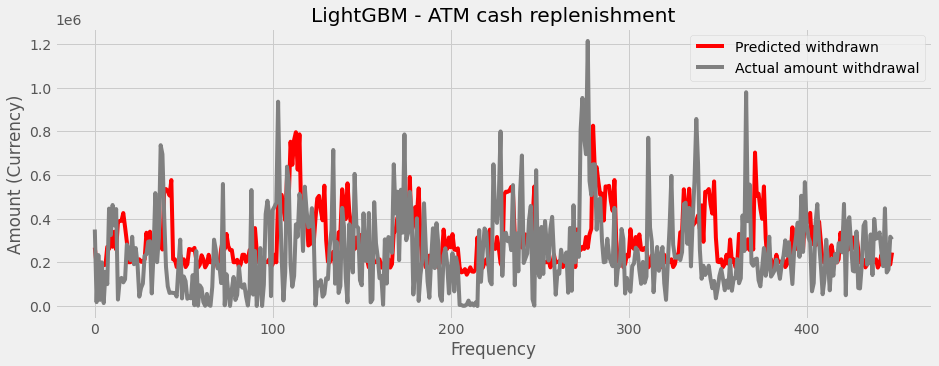

In [47]:
plt.figure(figsize = (14,5))
plt.plot(lgb_pred, color = 'red',label = 'Predicted withdrawn')
plt.plot(y_test, color = 'gray',label = 'Actual amount withdrawal')
plt.title ('LightGBM - ATM cash replenishment')
plt.xlabel('Frequency')
plt.ylabel('Amount (Currency)')
plt.legend()
plt.show()

In [ ]:
lgb_pred

In [ ]:
gbm.predict(X_test.iloc[[0]])

array([267730.73911932])

In [ ]:
X_test.iloc[[0]]

,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean
1795,Mount Road ATM,SUNDAY,NH,H,HHW,5,2,2016,293750


In [ ]:
y_test[-1:]

array([305100])

In [48]:
mean_lgb_test = y_test.mean()
mean_lgb_pred = lgb_pred.mean()
print(mean_lgb_test, mean_lgb_pred)

accuracy = (mean_lgb_test / mean_lgb_pred)*100
print(round(accuracy,2))

246600.89086859688 293727.72294823226
83.96


<IPython.core.display.Javascript object>

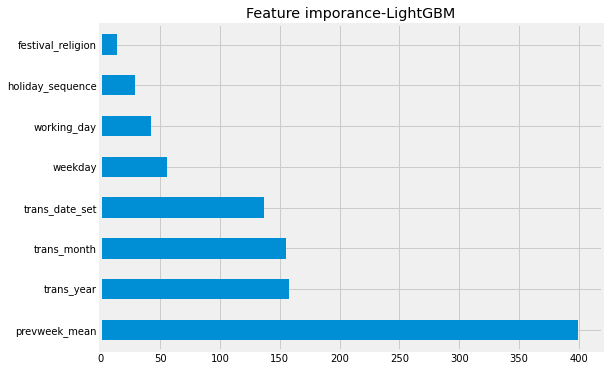

In [ ]:
feat_imp = pd.Series(gbm.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8, 6))
plt.title('Feature imporance-LightGBM')
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


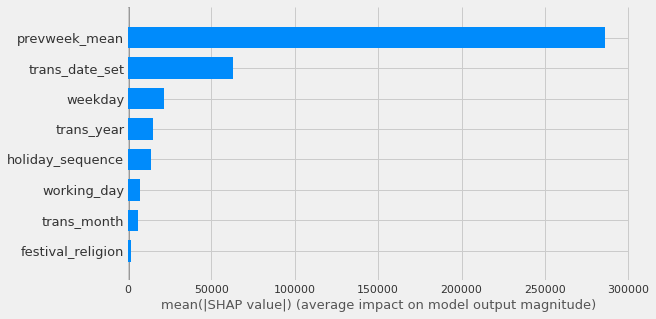

In [64]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

##CatBoost

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  1795 449
length of y_train and y_test:  1795 449


In [ ]:
cat = CatBoostRegressor(random_seed=42)

start = time()

cat.fit(
    X_train, y_train,
    cat_features = cat_cols,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10, 
    verbose=50,
    plot=True)

cat_elapse = time() - start
print('elapse:, ', cat_elapse)
print(); print(cat)

# make predictions
cat_pred = cat.predict(X_test)

Learning rate set to 0.051464


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 219748.5374101	test: 376585.7810657	best: 376585.7810657 (0)	total: 21.9ms	remaining: 21.9s
50:	learn: 169071.3197679	test: 219688.6451242	best: 219688.6451242 (50)	total: 292ms	remaining: 5.44s
100:	learn: 161437.6440823	test: 200942.0185541	best: 200942.0185541 (100)	total: 475ms	remaining: 4.22s
150:	learn: 156644.1010956	test: 196247.6955982	best: 196229.5443851 (146)	total: 615ms	remaining: 3.46s
200:	learn: 152622.2047247	test: 195831.6065237	best: 195599.7049384 (197)	total: 757ms	remaining: 3.01s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 195599.7049
bestIteration = 197

Shrink model to first 198 iterations.
elapse:,  0.8782105445861816



In [ ]:
mean_cat_test = y_test.mean()
mean_cat_pred = cat_pred.mean()
print(mean_cat_test, mean_cat_pred)

accuracy = (mean_cat_pred / mean_cat_test)*100
print('accuracy:', round(accuracy,2))

246600.89086859688 277165.84341114183
accuracy: 112.39


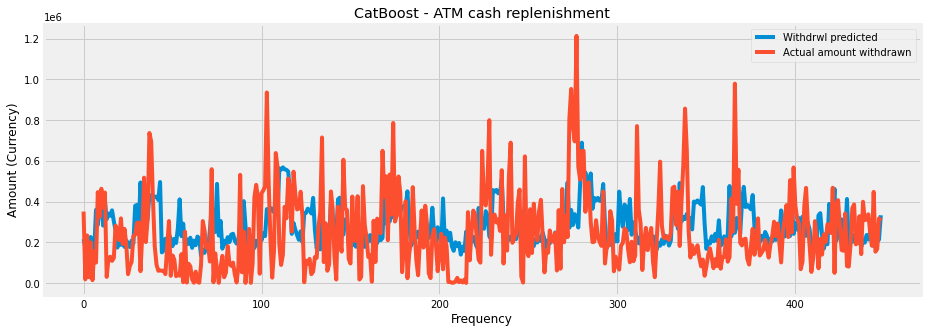

In [ ]:
plt.figure(figsize = (14,5))
plt.plot(cat_pred, label = 'Withdrwl predicted')
plt.plot(y_test, label = 'Actual amount withdrawn')
plt.title ('CatBoost - ATM cash replenishment')
plt.xlabel('Frequency')
plt.ylabel('Amount (Currency)')
plt.legend()
plt.show()

In [ ]:
cat.predict(X_test.iloc[[0]])

array([215510.94092118])

<IPython.core.display.Javascript object>

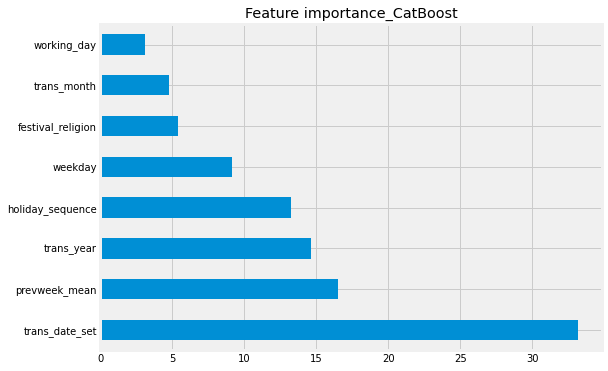

In [ ]:
featimp = pd.Series(cat.feature_importances_, index=X.columns)
featimp.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title('Feature importance_CatBoost')
plt.show()

In [ ]:
catpred = pd.DataFrame(cat_pred[-10:])
catpred.rename(columns = {0: 'cat_predicted'}, inplace=True)
catpred = catpred.round(decimals=0)

catok = pd.concat([catpred['cat_predicted'], d['total_amount_withdrawn'].tail(10)], axis=1)
catok

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,cat_predicted,total_amount_withdrawn
0,198002.0,308400
1,235345.0,312600
2,213685.0,337100
3,249329.0,251100
4,243029.0,182700
5,181678.0,447400
6,217245.0,153800
7,201877.0,167100
8,213344.0,317400
9,332566.0,305100


In [ ]:
final_result = pd.concat([catok['cat_predicted'], lgbok['lgb_predicted'], annok['ann_predicted'],
                        xgbok['xgb_predicted'], linok], axis=1)
final_result


<IPython.core.display.Javascript object>

,cat_predicted,lgb_predicted,ann_predicted,xgb_predicted,lin_predicted,total_amount_withdrawn
0,198002.0,214114.0,543390.0,125432.0,563741.0,308400
1,235345.0,176062.0,572483.0,282982.0,504511.0,312600
2,213685.0,192241.0,550465.0,127632.0,480476.0,337100
3,249329.0,234971.0,597518.0,147818.0,590279.0,251100
4,243029.0,197809.0,579181.0,8940.0,392997.0,182700
5,181678.0,203032.0,568751.0,251185.0,543618.0,447400
6,217245.0,199800.0,591620.0,294813.0,475461.0,153800
7,201877.0,214114.0,672476.0,253381.0,491898.0,167100
8,213344.0,190260.0,742972.0,244633.0,514318.0,317400
9,332566.0,244990.0,704591.0,2325.0,185883.0,305100
